<h1>04 - Evaluation</h1>

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [134]:
df = pd.read_csv('../datasets/data.csv')

In [135]:
# data preparation
df.columns = df.columns.str.lower().str.replace(' ', '_')

delete_list = ['engine_fuel_type', 'driven_wheels', 'number_of_doors', 'market_category', 'vehicle_size', 'popularity']

for column in delete_list:
    del df[column]

In [136]:
# fill any missing values with zero
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(0)

In [137]:
df.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
msrp                   int64
dtype: object

In [138]:
# make a binary column to track if prices are above or below average
mean_price = df.msrp.mean()
df['above_average'] = (df['msrp'] > mean_price).astype(int)

In [139]:
# split the dataset
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [140]:
len(df_full_train), len(df_train), len(df_test), len(df_val)

(9531, 7148, 2383, 2383)

In [141]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [142]:
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = ['make', 'model', 'transmission_type', 'vehicle_style']

<h1>Question 1</h1>
Which numerical variable has the highest AUC?

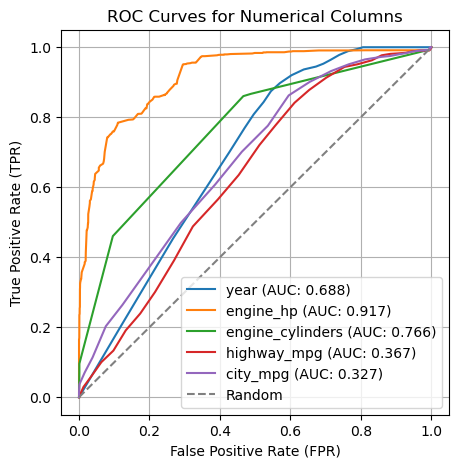

In [143]:
plt.figure(figsize=(5, 5))

for col in numerical:
    fpr, tpr, _ = roc_curve(y_train, df_train[col])
    if roc_auc_score(y_train, df_train[col]) < 0.5:
        fpr, tpr, _ = roc_curve(y_train, -df_train[col])
    
    auc = roc_auc_score(y_train, df_train[col])
    plt.plot(fpr, tpr, label=f'{col} (AUC: {auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Numerical Columns')
plt.legend()
plt.grid(True)
plt.show()

<h1>Question 2</h1>
What is the AUC of this model on the validation dataset?

In [147]:
dicts_train = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts_train)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

dicts_val = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(dicts_val)

y_pred = model.predict_proba(X_val)[:, 1]

print(f"AUC: {roc_auc_score(y_val, y_pred).round(3)}")

AUC: 0.98


<h1>Question 3</h1>
At which threshold do the precision and recall curves intersect?

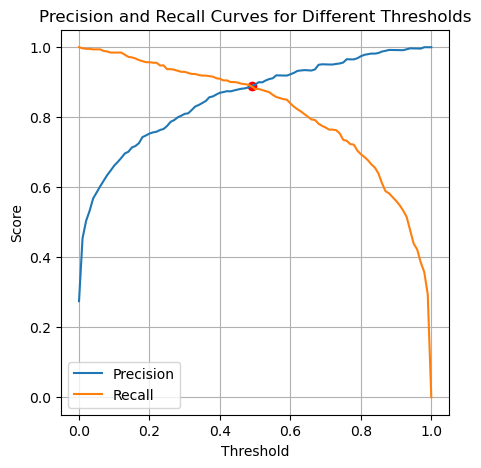

Intersection Threshold: 0.49


In [205]:
thresholds = np.linspace(0 , 1, 101)

precisions = []
recalls = []

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    precision = precision_score(y_val, predict_positive, zero_division=1)
    recall = recall_score(y_val, predict_positive)
    
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall curves
plt.figure(figsize=(5, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves for Different Thresholds')
plt.legend()
plt.grid(True)
plt.scatter(intersection, precisions[np.argmin(np.abs(np.array(precisions) - np.array(recalls)))], color='red', label='Intersection', marker='o')

plt.show()

intersection = thresholds[np.argmin(np.abs(np.array(precisions) - np.array(recalls)))]
print(f"Intersection Threshold: {intersection}")

<h1>Question 4</h1>
At what threshold is F1 maximal?

Highest F1: 0.89 Threshold: 0.51


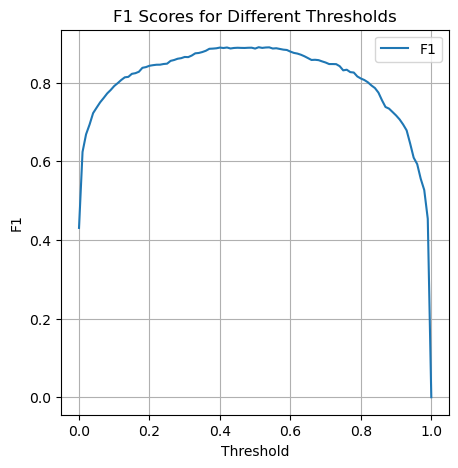

In [222]:
f1s = []

for i in range(len(thresholds)):
    p = precisions[i]
    r = recalls[i]
    f1 = 2 * ((p * r) / (p + r))
    f1s.append(f1)

plt.figure(figsize=(5, 5))
plt.plot(thresholds, f1s, label='F1')
plt.ylabel('F1')
plt.xlabel('Threshold')
plt.title('F1 Scores for Different Thresholds')
plt.legend()
plt.grid(True)

print(f"Highest F1: {max(f1s).round(2)} Threshold: {thresholds[np.argmax(f1s)]}")

<h1>Question 5</h1>
How large is the standard deviation of the scores across 5 folds?

In [265]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    # feature matrix
    X_train = dv.fit_transform(dicts)
    
    # C is regularization
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [268]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    
    dv, model = train(df_train, y_train, 1.0)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f"STD: {np.std(scores).round(3)}")

0it [00:00, ?it/s]

STD: 0.002


<h1>Question 6</h1>
What C leads to the best mean score?

In [269]:
for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print("C=%s %.3f +- %.3f" % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.002
C=0.5 0.978 +- 0.003
C=10 0.984 +- 0.003
